In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)

In [27]:
data = pd.read_csv('train2.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [28]:
#PassengerId - это уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет вид gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp - их номер в группе. Люди в группе часто являются членами семьи, но не всегда.
#Home planet - планета, с которой вылетел пассажир, как правило, их планета постоянного проживания.
#CryoSleep- указывает, решил ли пассажир погрузиться в анабиоз на время путешествия. Пассажиры, находящиеся в криосне, прикованы к своим каютам.
#Cabin - номер каюты, в которой находится пассажир. Принимает форму deck/num/side, где side может быть либо P для левого, либо S для правого борта.
#The destination - планета, на которой пассажир будет высаживаться.
#Age - возраст пассажира.
#VIP - оплатил ли пассажир специальное VIP-обслуживание во время рейса.
#RoomService, FoodCourt, ShoppingMall, Spa, VRdeck for relaxation- сумма, которую пассажир оплатил за все многочисленные роскошные удобства космического корабля "Титаник".
#Name - имя и фамилия пассажира.
#Transported - был ли пассажир перенесен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [30]:
data.isna().sum()
# В каждом столбце кроме PassengerID и целевого признака имеются пропуски, необходимо их заполнить

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Предобработка данных


1    4378
0    4315
Name: Transported, dtype: int64

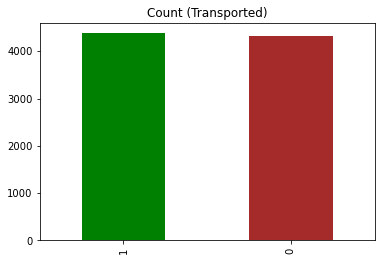

In [31]:
# Переведем наш целевой признак в бинарный вид и отобразим его:
data['Transported'] = data["Transported"].apply(lambda x: 0 if x == False else 1)
data.Transported.value_counts().plot(
    kind='bar', 
    title='Count (Transported)', 
    color = ['green', 'brown']
)
data['Transported'].value_counts()

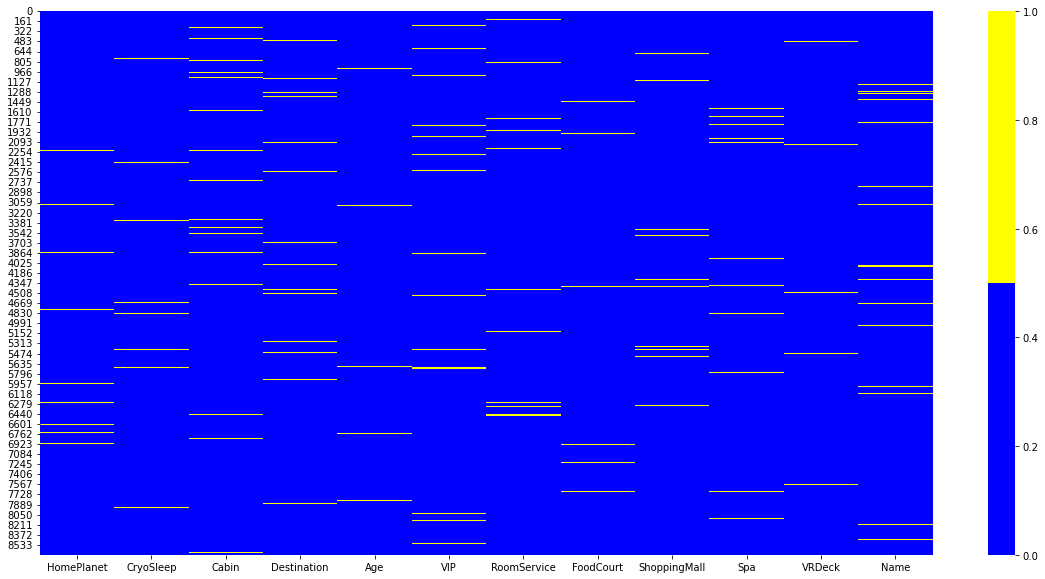

In [32]:
cols_null_percent = data.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0]
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(20, 10))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)
# Как мы видим пропуски построчно неоднородны, удаление строк нецелесообразно при прогнозировании,
#                                                                       поэтому для моделирования их необходимо заполнить

In [33]:
# Заполним пропуски для признака возраст:
age_avg = data['Age'].mean()
age_std = data['Age'].std()
age_null_count = data['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
data.loc[np.isnan(data['Age']), 'Age'] = age_null_random_list
data['Age'] = data['Age'].astype(int)

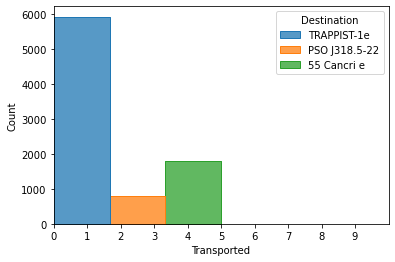

In [34]:
fig, ax = plt.subplots()
ax.set_xlim(0,10)
ax.set_xticks(range(0,10))
sns.histplot(x=data.Transported, 
             hue=data.Destination, 
             data=data, 
             element='step', 
             multiple='dodge',
             bins=range(0, 10, 5))
plt.show()


In [35]:
# Также заполним пропуски модальными значениями призанаков для столбцов: Destination, HomePlanet, CryoSleep, Vip
# Заменим NaN значения на None или 0, а так же зменим булевые значения на 0/1
#
data.loc[ (data.VIP == False), 'VIP'] = 0
data.loc[ (data.VIP == True), 'VIP'] = 1
#
data.loc[ (data.CryoSleep == False), 'CryoSleep'] = 0
data.loc[ (data.CryoSleep == True), 'CryoSleep'] = 1


In [36]:
# Поле Destination заменим на:
# - 0: TRAPPIST-1e
# - 1: PSO J318.5-22
# - 2: 55 Cancri e

data.loc[ (data.Destination == 'TRAPPIST-1e'), 'Destination'] = 0
data.loc[ (data.Destination == 'PSO J318.5-22'), 'Destination'] = 1
data.loc[ (data.Destination == '55 Cancri e'), 'Destination'] = 2
data['Destination'] = data['Destination'].fillna(4)

In [37]:
# Поле HomePlanet заменим на:
# - 0: Europa
# - 1: Earth
# - 2: Mars
#
data.loc[ (data.HomePlanet == 'Europa'), 'HomePlanet'] = 0
data.loc[ (data.HomePlanet == 'Earth'), 'HomePlanet'] = 1
data.loc[ (data.HomePlanet == 'Mars'), 'HomePlanet'] = 2
data['HomePlanet'] = data['HomePlanet'].fillna(4)

In [38]:
# Поле Transported заменим на:
# - 0: False
# - 1: True
#
data.loc[ (data.Transported == False), 'Transported'] = 0
data.loc[ (data.Transported == True), 'Transported'] = 1

In [39]:
data_n = data.loc[(data.CryoSleep == True) & (data.ShoppingMall != 0)]
res = data_n[['ShoppingMall', 'CryoSleep']]
res['ShoppingMall'].sum()
res

,ShoppingMall,CryoSleep
10,NaN,1
23,NaN,1
28,NaN,1
40,NaN,1
59,NaN,1
...,...,...
8493,NaN,1
8494,NaN,1
8583,NaN,1
8600,NaN,1


In [40]:
# Заменим пропущенные значения в CryoSleep если параметр RoomService = 0

data.loc[(data.ShoppingMall == 0), 'CryoSleep'] = 1

In [41]:
# Остальным Nan значениям присвоим 1

data.loc[ (data.ShoppingMall != 0), 'CryoSleep'] = 0

In [42]:
data["CryoSleep"] = data["CryoSleep"].astype(int)
data["Destination"] = data["Destination"].astype(int)
data["HomePlanet"] = data["HomePlanet"].astype(int)
data["Transported"] = data["Transported"].astype(int)

In [43]:
# Удалим строки со значениями NaN в полях Destination и HomePlanet
data.drop(data[data.Destination == 4].index, inplace=True)
data.drop(data[data.HomePlanet == 4].index, inplace=True)
data.describe()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8314.000000,8314.000000,8314.000000,8314.000000,8142.000000,8139.000000,8118.000000,8137.000000,8129.000000,8314.000000
mean,0.954655,0.642892,0.519365,28.782535,225.537829,465.207274,174.957502,311.711196,307.234715,0.503368
std,0.675561,0.479176,0.821738,14.423718,673.644748,1637.268381,609.228194,1132.136829,1158.307217,0.500019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,38.000000,47.000000,78.000000,27.000000,59.000000,45.000000,1.000000
max,2.000000,1.000000,2.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [44]:
# Удалим признаки, которые не несут предсказательной силы

data.drop(['Cabin','PassengerId', 'Name'], axis=1, inplace=True)

In [45]:
# Заменим Nan значения на 0
for col in ("ShoppingMall","RoomService", "Spa", "VRDeck", "FoodCourt"):
    data[col] = data[col].fillna(0)
    
# Заменим Nan значения на моду
data['VIP'] = data['VIP'].fillna(data['VIP'].mode()[0])

In [72]:
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,1,0,39,0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,24,0,109.0,9.0,25.0,549.0,44.0,1
2,0,1,0,58,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0,0,0,33,0,0.0,1283.0,371.0,3329.0,193.0,0
4,1,0,0,16,0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,2,41,1,0.0,6819.0,0.0,1643.0,74.0,0
8689,1,1,1,18,0,0.0,0.0,0.0,0.0,0.0,0
8690,1,0,0,26,0,0.0,0.0,1872.0,1.0,0.0,1
8691,0,1,2,32,0,0.0,1049.0,0.0,353.0,3235.0,0


<AxesSubplot:>

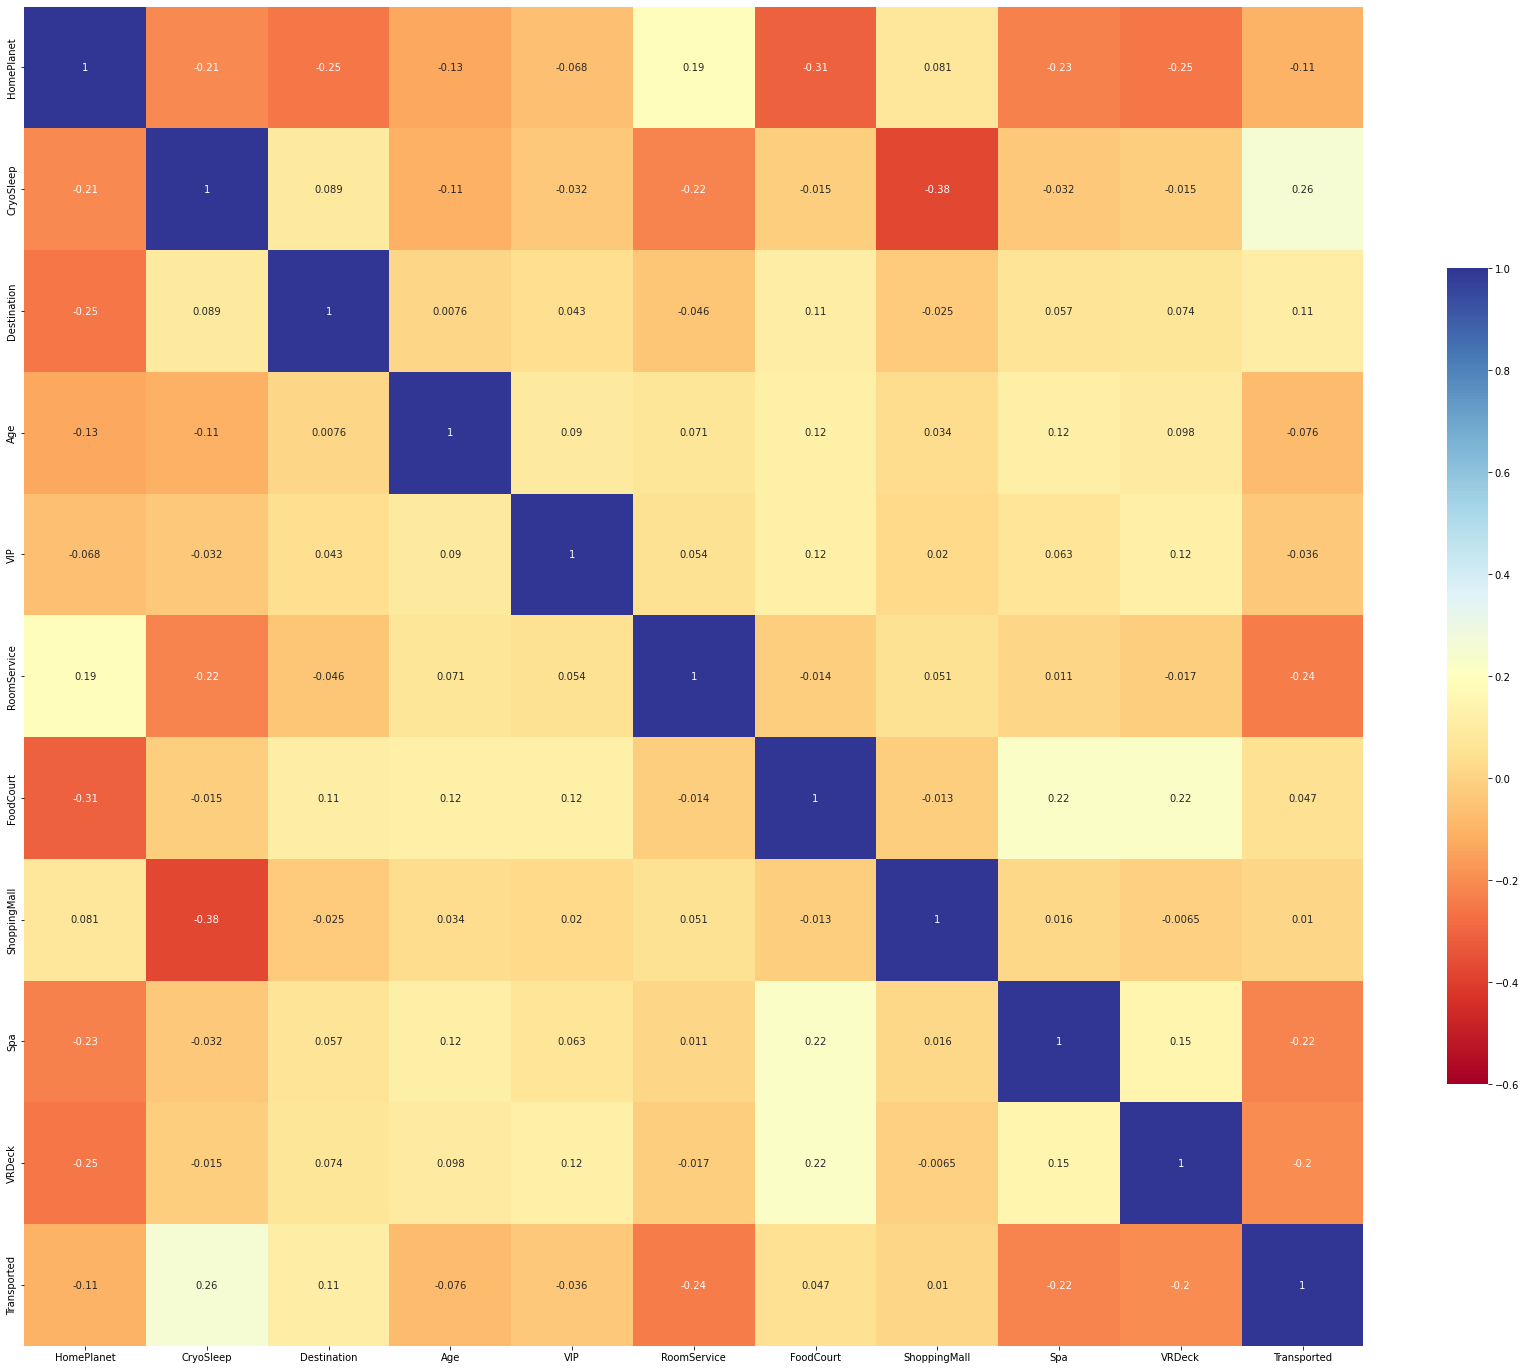

In [47]:
# Все признаки нормально коррелируют с целевым параметром, а также отсутствует мультиколлинеарность.

plt.figure(figsize=(30, 30))
sns.heatmap(data.corr(),cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True)

## Обучение данных


In [52]:
X = data.drop('Transported', axis=1)
y = data['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [56]:
num = []

for i in range(2,20):
    decision_tree = DecisionTreeClassifier(max_depth = i)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    num.append([accuracy_score(y_test, y_pred),f1_score(y_test, y_pred)])
    print(i, [accuracy_score(y_test, y_pred),f1_score(y_test, y_pred)])

2 [0.717434869739479, 0.7234209493919185]
3 [0.7482965931863728, 0.7515822784810128]
4 [0.7591182364729459, 0.7655091689426452]
5 [0.7659318637274549, 0.7863935625457206]
6 [0.765130260521042, 0.7770167427701674]
7 [0.7731462925851703, 0.7952243125904487]
8 [0.7683366733466934, 0.7836826347305389]
9 [0.7575150300601202, 0.7781444811147782]
10 [0.7551102204408817, 0.7746219107340465]
11 [0.7486973947895792, 0.7611428571428572]
12 [0.7478957915831663, 0.7614713689799014]
13 [0.7434869739478958, 0.7597597597597597]
14 [0.737875751503006, 0.7539503386004515]
15 [0.7350701402805612, 0.7499054105183504]
16 [0.7342685370741483, 0.7497168742921857]
17 [0.7314629258517034, 0.7483095416979715]
18 [0.7230460921843688, 0.7437893956247682]
19 [0.7210420841683367, 0.7397157816005983]


In [54]:
num_2 = []

for i in range(2,20):
    decision_tree = RandomForestClassifier(max_depth = i)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    num_2.append( [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)] )
    print(i, [accuracy_score(y_test, y_pred),f1_score(y_test, y_pred)])
    

2 [0.7318637274549098, 0.7261563651248466]
3 [0.7454909819639278, 0.7361861238055671]
4 [0.7627254509018037, 0.7612903225806452]
5 [0.779559118236473, 0.7858255451713394]
6 [0.7783567134268538, 0.7891727030118185]
7 [0.7811623246492986, 0.7938066465256798]
8 [0.7811623246492986, 0.795198799699925]
9 [0.7827655310621242, 0.7970037453183519]
10 [0.7803607214428858, 0.7950635751682872]
11 [0.781563126252505, 0.7962616822429907]
12 [0.7755511022044088, 0.7883597883597883]
13 [0.7771543086172344, 0.7868098159509203]
14 [0.7787575150300601, 0.787201233616037]
15 [0.7803607214428858, 0.7879256965944272]
16 [0.7807615230460921, 0.7887215140981074]
17 [0.7787575150300601, 0.7850467289719625]
18 [0.7775551102204409, 0.7831184056271981]
19 [0.7811623246492986, 0.7878787878787878]


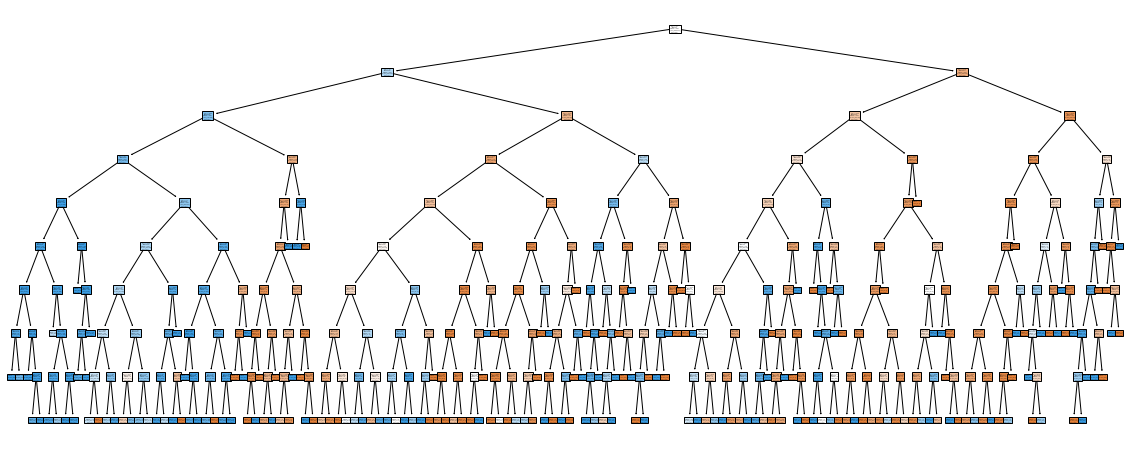

In [73]:
# Заметим, что наилучшего результата мы добились при глубине дерева равной 9, построим график:

decision_tree = DecisionTreeClassifier(max_depth = 9)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

plt.figure(figsize=(20, 8))
tr = tree.plot_tree(decision_tree, class_names=True, filled=True)

In [58]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.7735470941883767
Precision: 0.7433987813134733
Recall: 0.8551401869158879
F1 score: 0.7953639985512496


## Попробуем подобрать параметры с помощью модуля GridSearchCV

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
clf = RandomForestClassifier()

In [69]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [70]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [71]:
# Получаем наилучшие параметры для нашей модели
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20}
0.7975615557584514
RandomForestClassifier(max_depth=9, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=20)
